# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.533201 -1.022194  0.0  0.179820 -0.126268 -0.665279  0  2   0.377309   
1  1.922557 -0.762009  0.0  0.899564 -0.229440 -1.197794  1  1   9.944403   
2  1.171414  1.479419  1.0  0.513904  0.987447  0.439091  0  2  24.655594   
3  0.484425 -1.845972  0.0  0.387353  1.517763 -0.685227  0  3  13.782830   
4  1.122992  0.385469  0.0  0.313835  0.115356  2.225336  1  1  17.397334   

            y  
0    1.888306  
1   84.051100  
2  399.830888  
3   65.517166  
4  220.655496  
True causal estimate is 9.049694403977


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

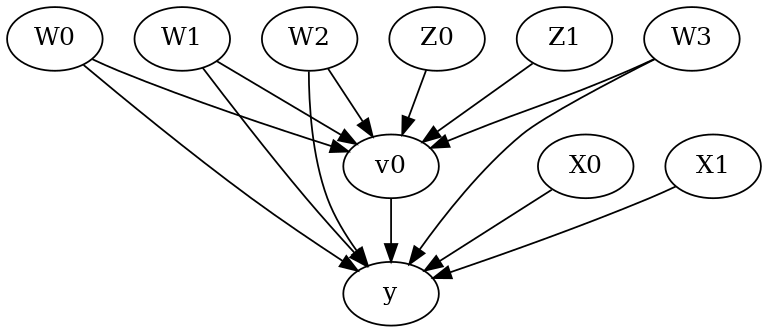

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W1,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W1,W3,U) = P(y|v0,W2,W0,W1,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W1,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W1,W3,U) = P(y|v0,W2,W0,W1,W3)

## Realized estimand
b: y~v0+W2+W0+W1+W3+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 9.049415183121157
### Conditional Estimates
__categorical__X0              __categorical__X1
(-3.5749999999999997, -0.687]  (-4.484, -1.15]       3.288129
                               (-1.15, -0.562]       6.267303
                               (-0.562, -0.0573]     8.040084
                               (-0.0573, 0.538]      9.904973
                               (0.538, 3.207]       12.728653
(-0.687, -0.0947]              (-4.484, -1.15]       3.897843
                               (-1.15, -0.562]       6.885845
                               (-0.562, -0.0573]    

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

2022-09-14 18:44:20.050299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-14 18:44:20.050337: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W1,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W1,W3,U) = P(y|v0,W2,W0,W1,W3)

## Realized estimand
b: y~v0+W2+W0+W1+W3 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 10.073101008999998
Effect estimates: [ 8.75174232 15.87229533 12.10883134 ...  7.61828507  2.48628422
  9.32302822]



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 9.049694403977


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W1,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W1,W3,U) = P(y|v0,W2,W0,W1,W3)

## Realized estimand
b: y~v0+W2+W0+W1+W3 | X0,X1
Target units: 

## Estimate
Mean value: 9.0105851188843
Effect estimates: [ 6.15557119  8.64699923 15.73603354 ... 15.87179788  8.05935455
  8.75923011]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W1,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W1,W3,U) = P(y|v0,W2,W0,W1,W3)

## Realized estimand
b: y~v0+W2+W0+W1+W3 | X0,X1
Target units: ate

## Estimate
Mean value: 8.97103120997889
Effect estimates: [ 6.11637397  8.57762811 15.70466462 ... 15.84544308  8.00633323
  8.73332712]
95.0% confidence interval: (array([ 6.04294108,  8.42758643, 15.77291365, ..., 15.92144005,
        7.93937896,  8.75143052]), array([ 6.18996505,  8.66689443, 16.17018427, ..., 16.33172413,
        8.06900788,  8.91158551]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[11.04119185 13.14994662 10.35837984 12.47894912 11.36113085 13.39935511
 13.90418027 10.28889381 12.38958317 12.97335591]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.977022  1.067383  1.0  0.696816  0.877629 -0.704097 -2.705619   
1     0.119435  1.646813  1.0  0.932599  1.045068 -1.503361 -0.811373   
2     2.368885  2.055748  1.0  0.551497  0.832655 -0.056771 -2.144246   
3    -0.256994  0.945261  1.0  0.614187 -1.904988 -1.624514 -1.838845   
4     2.329471  1.215418  1.0  0.647074  2.402067 -0.312094 -1.590205   
...        ...       ...  ...       ...       ...       ...       ...   
9995  1.327564  3.895272  0.0  0.974441  1.724229 -0.534615  0.062941   
9996  0.095342  1.142415  1.0  0.890541  1.315665 -0.436278 -0.964123   
9997  0.909117  1.771237  1.0  0.402906  1.189027 -0.175096 -0.514647   
9998  0.199285  2.383161  1.0  0.166742 -1.331729 -0.409680 -0.525951   
9999  2.682434  0.140926  1.0  0.880121  0.744858 -0.319757 -1.370824   

            W3  v0  y  
0    -1.050106   1  1  
1    -0.392080   1  1  
2    -1.936656   1  1  
3     0.332871   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W1,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W1,W3,U) = P(y|v0,W2,W0,W1,W3)

## Realized estimand
b: y~v0+W2+W0+W1+W3 | X0,X1
Target units: ate

## Estimate
Mean value: 0.6073356972078376
Effect estimates: [0.64530812 0.64334411 0.61774472 ... 0.633828   0.66240192 0.55963395]

True causal estimate is 0.4818


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-09-14 18:47:39.639288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-14 18:47:39.639334: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-14 18:47:39.639362: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (37c5f4ec8b0f): /proc/driver/nvidia/version does not exist
2022-09-14 18:47:39.639675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:49 - loss: 191.9641

 28/313 [=>............................] - ETA: 0s - loss: 85.0974   

 56/313 [====>.........................] - ETA: 0s - loss: 46.3313

 85/313 [=======>......................] - ETA: 0s - loss: 32.2390

114/313 [=========>....................] - ETA: 0s - loss: 25.2052

143/313 [============>.................] - ETA: 0s - loss: 21.0148

172/313 [===============>..............] - ETA: 0s - loss: 18.2036

196/313 [=================>............] - ETA: 0s - loss: 16.5192

223/313 [====================>.........] - ETA: 0s - loss: 15.0498

252/313 [=======================>......] - ETA: 0s - loss: 13.8206

280/313 [=========================>....] - ETA: 0s - loss: 12.8682

308/313 [============================>.] - ETA: 0s - loss: 12.0840

313/313 [==============================] - 1s 2ms/step - loss: 11.9591


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 4.2613

 30/313 [=>............................] - ETA: 0s - loss: 4.1916

 58/313 [====>.........................] - ETA: 0s - loss: 4.2059

 86/313 [=======>......................] - ETA: 0s - loss: 4.1743

114/313 [=========>....................] - ETA: 0s - loss: 4.1631

142/313 [============>.................] - ETA: 0s - loss: 4.1492

170/313 [===============>..............] - ETA: 0s - loss: 4.1391

198/313 [=================>............] - ETA: 0s - loss: 4.1197

226/313 [====================>.........] - ETA: 0s - loss: 4.1024

254/313 [=======================>......] - ETA: 0s - loss: 4.0875

283/313 [==========================>...] - ETA: 0s - loss: 4.0673

311/313 [============================>.] - ETA: 0s - loss: 4.0454

313/313 [==============================] - 1s 2ms/step - loss: 4.0460


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3.9356

 28/313 [=>............................] - ETA: 0s - loss: 3.7805

 56/313 [====>.........................] - ETA: 0s - loss: 3.8044

 84/313 [=======>......................] - ETA: 0s - loss: 3.7602

113/313 [=========>....................] - ETA: 0s - loss: 3.7115

140/313 [============>.................] - ETA: 0s - loss: 3.6578

168/313 [===============>..............] - ETA: 0s - loss: 3.5867

198/313 [=================>............] - ETA: 0s - loss: 3.5111

225/313 [====================>.........] - ETA: 0s - loss: 3.4553

253/313 [=======================>......] - ETA: 0s - loss: 3.4033

279/313 [=========================>....] - ETA: 0s - loss: 3.3607

305/313 [============================>.] - ETA: 0s - loss: 3.3250

313/313 [==============================] - 1s 2ms/step - loss: 3.3135


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.6889

 29/313 [=>............................] - ETA: 0s - loss: 2.9001

 57/313 [====>.........................] - ETA: 0s - loss: 2.8947

 85/313 [=======>......................] - ETA: 0s - loss: 2.8779

114/313 [=========>....................] - ETA: 0s - loss: 2.8434

142/313 [============>.................] - ETA: 0s - loss: 2.8374

171/313 [===============>..............] - ETA: 0s - loss: 2.8186

195/313 [=================>............] - ETA: 0s - loss: 2.8167

216/313 [===================>..........] - ETA: 0s - loss: 2.8106

244/313 [======================>.......] - ETA: 0s - loss: 2.8005

270/313 [========================>.....] - ETA: 0s - loss: 2.7981

298/313 [===========================>..] - ETA: 0s - loss: 2.7948

313/313 [==============================] - 1s 2ms/step - loss: 2.7917


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.6977

 28/313 [=>............................] - ETA: 0s - loss: 2.6910

 55/313 [====>.........................] - ETA: 0s - loss: 2.7049

 82/313 [======>.......................] - ETA: 0s - loss: 2.7281

111/313 [=========>....................] - ETA: 0s - loss: 2.7178

140/313 [============>.................] - ETA: 0s - loss: 2.7176

169/313 [===============>..............] - ETA: 0s - loss: 2.7093

198/313 [=================>............] - ETA: 0s - loss: 2.7067

223/313 [====================>.........] - ETA: 0s - loss: 2.7009

249/313 [======================>.......] - ETA: 0s - loss: 2.7038

275/313 [=========================>....] - ETA: 0s - loss: 2.6984

302/313 [===========================>..] - ETA: 0s - loss: 2.6982

313/313 [==============================] - 1s 2ms/step - loss: 2.6947


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.4862

 30/313 [=>............................] - ETA: 0s - loss: 2.6212

 58/313 [====>.........................] - ETA: 0s - loss: 2.6206

 86/313 [=======>......................] - ETA: 0s - loss: 2.6269

115/313 [==========>...................] - ETA: 0s - loss: 2.6213

141/313 [============>.................] - ETA: 0s - loss: 2.6153

166/313 [==============>...............] - ETA: 0s - loss: 2.6224

193/313 [=================>............] - ETA: 0s - loss: 2.6272

221/313 [====================>.........] - ETA: 0s - loss: 2.6257

249/313 [======================>.......] - ETA: 0s - loss: 2.6317

277/313 [=========================>....] - ETA: 0s - loss: 2.6353

305/313 [============================>.] - ETA: 0s - loss: 2.6362

313/313 [==============================] - 1s 2ms/step - loss: 2.6366


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.8140

 30/313 [=>............................] - ETA: 0s - loss: 2.6444

 60/313 [====>.........................] - ETA: 0s - loss: 2.6604

 91/313 [=======>......................] - ETA: 0s - loss: 2.6521

115/313 [==========>...................] - ETA: 0s - loss: 2.6475

144/313 [============>.................] - ETA: 0s - loss: 2.6269

174/313 [===============>..............] - ETA: 0s - loss: 2.6277

203/313 [==================>...........] - ETA: 0s - loss: 2.6184

232/313 [=====================>........] - ETA: 0s - loss: 2.6176

261/313 [========================>.....] - ETA: 0s - loss: 2.6124

289/313 [==========================>...] - ETA: 0s - loss: 2.6094

313/313 [==============================] - 1s 2ms/step - loss: 2.6077


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 2.4358

 29/313 [=>............................] - ETA: 0s - loss: 2.5606

 58/313 [====>.........................] - ETA: 0s - loss: 2.5634

 88/313 [=======>......................] - ETA: 0s - loss: 2.5900

117/313 [==========>...................] - ETA: 0s - loss: 2.5840

146/313 [============>.................] - ETA: 0s - loss: 2.5832

176/313 [===============>..............] - ETA: 0s - loss: 2.5827

201/313 [==================>...........] - ETA: 0s - loss: 2.5865

229/313 [====================>.........] - ETA: 0s - loss: 2.5932

258/313 [=======================>......] - ETA: 0s - loss: 2.5904

287/313 [==========================>...] - ETA: 0s - loss: 2.5874

313/313 [==============================] - 1s 2ms/step - loss: 2.5855


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.5677

 28/313 [=>............................] - ETA: 0s - loss: 2.5480

 53/313 [====>.........................] - ETA: 0s - loss: 2.5520

 81/313 [======>.......................] - ETA: 0s - loss: 2.5569

110/313 [=========>....................] - ETA: 0s - loss: 2.5684

140/313 [============>.................] - ETA: 0s - loss: 2.5790

169/313 [===============>..............] - ETA: 0s - loss: 2.5836

198/313 [=================>............] - ETA: 0s - loss: 2.5701

227/313 [====================>.........] - ETA: 0s - loss: 2.5666

256/313 [=======================>......] - ETA: 0s - loss: 2.5654

284/313 [==========================>...] - ETA: 0s - loss: 2.5614

313/313 [==============================] - ETA: 0s - loss: 2.5629

313/313 [==============================] - 1s 2ms/step - loss: 2.5629


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.6884

 29/313 [=>............................] - ETA: 0s - loss: 2.4973

 59/313 [====>.........................] - ETA: 0s - loss: 2.5221

 87/313 [=======>......................] - ETA: 0s - loss: 2.5381

117/313 [==========>...................] - ETA: 0s - loss: 2.5429

147/313 [=============>................] - ETA: 0s - loss: 2.5422

177/313 [===============>..............] - ETA: 0s - loss: 2.5386

207/313 [==================>...........] - ETA: 0s - loss: 2.5438

237/313 [=====================>........] - ETA: 0s - loss: 2.5441

268/313 [========================>.....] - ETA: 0s - loss: 2.5451

298/313 [===========================>..] - ETA: 0s - loss: 2.5422

313/313 [==============================] - 1s 2ms/step - loss: 2.5409


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 2.3860

 33/313 [==>...........................] - ETA: 0s - loss: 2.5276

 63/313 [=====>........................] - ETA: 0s - loss: 2.5374

 91/313 [=======>......................] - ETA: 0s - loss: 2.5286

118/313 [==========>...................] - ETA: 0s - loss: 2.5347

145/313 [============>.................] - ETA: 0s - loss: 2.5291

171/313 [===============>..............] - ETA: 0s - loss: 2.5312

200/313 [==================>...........] - ETA: 0s - loss: 2.5360

230/313 [=====================>........] - ETA: 0s - loss: 2.5323

259/313 [=======================>......] - ETA: 0s - loss: 2.5374

289/313 [==========================>...] - ETA: 0s - loss: 2.5385

313/313 [==============================] - 1s 2ms/step - loss: 2.5363


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.7671

 30/313 [=>............................] - ETA: 0s - loss: 2.5219

 59/313 [====>.........................] - ETA: 0s - loss: 2.5142

 87/313 [=======>......................] - ETA: 0s - loss: 2.5106

116/313 [==========>...................] - ETA: 0s - loss: 2.5183

143/313 [============>.................] - ETA: 0s - loss: 2.5202

170/313 [===============>..............] - ETA: 0s - loss: 2.5244

198/313 [=================>............] - ETA: 0s - loss: 2.5226

226/313 [====================>.........] - ETA: 0s - loss: 2.5219

254/313 [=======================>......] - ETA: 0s - loss: 2.5256

282/313 [==========================>...] - ETA: 0s - loss: 2.5250

310/313 [============================>.] - ETA: 0s - loss: 2.5224

313/313 [==============================] - 1s 2ms/step - loss: 2.5217


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 2.4286

 30/313 [=>............................] - ETA: 0s - loss: 2.5167

 59/313 [====>.........................] - ETA: 0s - loss: 2.5140

 88/313 [=======>......................] - ETA: 0s - loss: 2.5216

117/313 [==========>...................] - ETA: 0s - loss: 2.5138

146/313 [============>.................] - ETA: 0s - loss: 2.5093

174/313 [===============>..............] - ETA: 0s - loss: 2.5132

201/313 [==================>...........] - ETA: 0s - loss: 2.5147

229/313 [====================>.........] - ETA: 0s - loss: 2.5132

258/313 [=======================>......] - ETA: 0s - loss: 2.5152

287/313 [==========================>...] - ETA: 0s - loss: 2.5167

313/313 [==============================] - 1s 2ms/step - loss: 2.5183


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 2.4344

 29/313 [=>............................] - ETA: 0s - loss: 2.4687

 57/313 [====>.........................] - ETA: 0s - loss: 2.5095

 86/313 [=======>......................] - ETA: 0s - loss: 2.5054

113/313 [=========>....................] - ETA: 0s - loss: 2.5052

139/313 [============>.................] - ETA: 0s - loss: 2.5049

167/313 [===============>..............] - ETA: 0s - loss: 2.5067

196/313 [=================>............] - ETA: 0s - loss: 2.5085

225/313 [====================>.........] - ETA: 0s - loss: 2.5041

254/313 [=======================>......] - ETA: 0s - loss: 2.5055

283/313 [==========================>...] - ETA: 0s - loss: 2.5092

311/313 [============================>.] - ETA: 0s - loss: 2.5100

313/313 [==============================] - 1s 2ms/step - loss: 2.5099


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.5033

 30/313 [=>............................] - ETA: 0s - loss: 2.4867

 59/313 [====>.........................] - ETA: 0s - loss: 2.5044

 89/313 [=======>......................] - ETA: 0s - loss: 2.4953

120/313 [==========>...................] - ETA: 0s - loss: 2.4986

151/313 [=============>................] - ETA: 0s - loss: 2.5020

181/313 [================>.............] - ETA: 0s - loss: 2.5038

211/313 [===================>..........] - ETA: 0s - loss: 2.5046

241/313 [======================>.......] - ETA: 0s - loss: 2.5054

269/313 [========================>.....] - ETA: 0s - loss: 2.5066

295/313 [===========================>..] - ETA: 0s - loss: 2.5111

313/313 [==============================] - 1s 2ms/step - loss: 2.5105


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.5528

 29/313 [=>............................] - ETA: 0s - loss: 2.5083

 58/313 [====>.........................] - ETA: 0s - loss: 2.5152

 85/313 [=======>......................] - ETA: 0s - loss: 2.5018

110/313 [=========>....................] - ETA: 0s - loss: 2.5103

138/313 [============>.................] - ETA: 0s - loss: 2.5181

165/313 [==============>...............] - ETA: 0s - loss: 2.5163

192/313 [=================>............] - ETA: 0s - loss: 2.5171

220/313 [====================>.........] - ETA: 0s - loss: 2.5141

248/313 [======================>.......] - ETA: 0s - loss: 2.5119

277/313 [=========================>....] - ETA: 0s - loss: 2.5131

306/313 [============================>.] - ETA: 0s - loss: 2.5084

313/313 [==============================] - 1s 2ms/step - loss: 2.5087


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.4429

 30/313 [=>............................] - ETA: 0s - loss: 2.4993

 59/313 [====>.........................] - ETA: 0s - loss: 2.5156

 89/313 [=======>......................] - ETA: 0s - loss: 2.5093

119/313 [==========>...................] - ETA: 0s - loss: 2.4874

149/313 [=============>................] - ETA: 0s - loss: 2.4803

178/313 [================>.............] - ETA: 0s - loss: 2.4865

207/313 [==================>...........] - ETA: 0s - loss: 2.4898

237/313 [=====================>........] - ETA: 0s - loss: 2.4881

267/313 [========================>.....] - ETA: 0s - loss: 2.4891

297/313 [===========================>..] - ETA: 0s - loss: 2.4858

313/313 [==============================] - 1s 2ms/step - loss: 2.4881


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.4083

 31/313 [=>............................] - ETA: 0s - loss: 2.4859

 62/313 [====>.........................] - ETA: 0s - loss: 2.4878

 92/313 [=======>......................] - ETA: 0s - loss: 2.4885

122/313 [==========>...................] - ETA: 0s - loss: 2.4821

151/313 [=============>................] - ETA: 0s - loss: 2.4858

180/313 [================>.............] - ETA: 0s - loss: 2.4888

208/313 [==================>...........] - ETA: 0s - loss: 2.4912

238/313 [=====================>........] - ETA: 0s - loss: 2.4878

267/313 [========================>.....] - ETA: 0s - loss: 2.4929

295/313 [===========================>..] - ETA: 0s - loss: 2.4888

313/313 [==============================] - 1s 2ms/step - loss: 2.4904


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.5351

 30/313 [=>............................] - ETA: 0s - loss: 2.5344

 57/313 [====>.........................] - ETA: 0s - loss: 2.5249

 86/313 [=======>......................] - ETA: 0s - loss: 2.5099

114/313 [=========>....................] - ETA: 0s - loss: 2.4966

143/313 [============>.................] - ETA: 0s - loss: 2.4980

172/313 [===============>..............] - ETA: 0s - loss: 2.4983

201/313 [==================>...........] - ETA: 0s - loss: 2.4951

231/313 [=====================>........] - ETA: 0s - loss: 2.4949

260/313 [=======================>......] - ETA: 0s - loss: 2.4915

289/313 [==========================>...] - ETA: 0s - loss: 2.4948

313/313 [==============================] - 1s 2ms/step - loss: 2.4946


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.4071

 29/313 [=>............................] - ETA: 0s - loss: 2.4669

 58/313 [====>.........................] - ETA: 0s - loss: 2.4782

 86/313 [=======>......................] - ETA: 0s - loss: 2.4897

116/313 [==========>...................] - ETA: 0s - loss: 2.4945

140/313 [============>.................] - ETA: 0s - loss: 2.4898

166/313 [==============>...............] - ETA: 0s - loss: 2.4883

194/313 [=================>............] - ETA: 0s - loss: 2.4853

224/313 [====================>.........] - ETA: 0s - loss: 2.4879

251/313 [=======================>......] - ETA: 0s - loss: 2.4871

281/313 [=========================>....] - ETA: 0s - loss: 2.4886

312/313 [============================>.] - ETA: 0s - loss: 2.4889

313/313 [==============================] - 1s 2ms/step - loss: 2.4887


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.3228

 32/313 [==>...........................] - ETA: 0s - loss: 2.4518

 60/313 [====>.........................] - ETA: 0s - loss: 2.4961

 88/313 [=======>......................] - ETA: 0s - loss: 2.4981

118/313 [==========>...................] - ETA: 0s - loss: 2.4928

148/313 [=============>................] - ETA: 0s - loss: 2.4920

177/313 [===============>..............] - ETA: 0s - loss: 2.4932

207/313 [==================>...........] - ETA: 0s - loss: 2.4862

236/313 [=====================>........] - ETA: 0s - loss: 2.4933

265/313 [========================>.....] - ETA: 0s - loss: 2.4915

294/313 [===========================>..] - ETA: 0s - loss: 2.4909

313/313 [==============================] - 1s 2ms/step - loss: 2.4925


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.3184

 31/313 [=>............................] - ETA: 0s - loss: 2.4901

 62/313 [====>.........................] - ETA: 0s - loss: 2.4818

 91/313 [=======>......................] - ETA: 0s - loss: 2.4877

121/313 [==========>...................] - ETA: 0s - loss: 2.4815

150/313 [=============>................] - ETA: 0s - loss: 2.4790

172/313 [===============>..............] - ETA: 0s - loss: 2.4827

200/313 [==================>...........] - ETA: 0s - loss: 2.4800

229/313 [====================>.........] - ETA: 0s - loss: 2.4919

257/313 [=======================>......] - ETA: 0s - loss: 2.4906

285/313 [==========================>...] - ETA: 0s - loss: 2.4883

313/313 [==============================] - ETA: 0s - loss: 2.4871

313/313 [==============================] - 1s 2ms/step - loss: 2.4871


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.5619

 30/313 [=>............................] - ETA: 0s - loss: 2.4493

 59/313 [====>.........................] - ETA: 0s - loss: 2.4929

 88/313 [=======>......................] - ETA: 0s - loss: 2.4909

116/313 [==========>...................] - ETA: 0s - loss: 2.4924

144/313 [============>.................] - ETA: 0s - loss: 2.4877

173/313 [===============>..............] - ETA: 0s - loss: 2.4914

201/313 [==================>...........] - ETA: 0s - loss: 2.4878

230/313 [=====================>........] - ETA: 0s - loss: 2.4846

258/313 [=======================>......] - ETA: 0s - loss: 2.4833

287/313 [==========================>...] - ETA: 0s - loss: 2.4769

313/313 [==============================] - 1s 2ms/step - loss: 2.4811


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.4176

 31/313 [=>............................] - ETA: 0s - loss: 2.4738

 58/313 [====>.........................] - ETA: 0s - loss: 2.4650

 87/313 [=======>......................] - ETA: 0s - loss: 2.4628

114/313 [=========>....................] - ETA: 0s - loss: 2.4676

144/313 [============>.................] - ETA: 0s - loss: 2.4788

173/313 [===============>..............] - ETA: 0s - loss: 2.4774

203/313 [==================>...........] - ETA: 0s - loss: 2.4760

233/313 [=====================>........] - ETA: 0s - loss: 2.4774

263/313 [========================>.....] - ETA: 0s - loss: 2.4804

293/313 [===========================>..] - ETA: 0s - loss: 2.4792

313/313 [==============================] - 1s 2ms/step - loss: 2.4775


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.5020

 31/313 [=>............................] - ETA: 0s - loss: 2.4663

 61/313 [====>.........................] - ETA: 0s - loss: 2.4583

 87/313 [=======>......................] - ETA: 0s - loss: 2.4606

118/313 [==========>...................] - ETA: 0s - loss: 2.4702

148/313 [=============>................] - ETA: 0s - loss: 2.4746

176/313 [===============>..............] - ETA: 0s - loss: 2.4713

206/313 [==================>...........] - ETA: 0s - loss: 2.4723

235/313 [=====================>........] - ETA: 0s - loss: 2.4717

265/313 [========================>.....] - ETA: 0s - loss: 2.4744

294/313 [===========================>..] - ETA: 0s - loss: 2.4752

313/313 [==============================] - 1s 2ms/step - loss: 2.4735


Epoch 1/25


  1/313 [..............................] - ETA: 4:15 - loss: 65284.8242

 21/313 [=>............................] - ETA: 0s - loss: 62505.4805  

 43/313 [===>..........................] - ETA: 0s - loss: 52225.5156

 65/313 [=====>........................] - ETA: 0s - loss: 41319.9492

 86/313 [=======>......................] - ETA: 0s - loss: 35684.7227

107/313 [=========>....................] - ETA: 0s - loss: 32470.4883

130/313 [===========>..................] - ETA: 0s - loss: 29544.9102

154/313 [=============>................] - ETA: 0s - loss: 27421.0391

177/313 [===============>..............] - ETA: 0s - loss: 26051.8652

200/313 [==================>...........] - ETA: 0s - loss: 24963.8281

223/313 [====================>.........] - ETA: 0s - loss: 24015.1191

246/313 [======================>.......] - ETA: 0s - loss: 23157.4980

269/313 [========================>.....] - ETA: 0s - loss: 22344.0039

293/313 [===========================>..] - ETA: 0s - loss: 21595.2715

313/313 [==============================] - 2s 2ms/step - loss: 21077.2461


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 8843.7422

 26/313 [=>............................] - ETA: 0s - loss: 12777.7393

 48/313 [===>..........................] - ETA: 0s - loss: 11881.3076

 70/313 [=====>........................] - ETA: 0s - loss: 11581.4609

 93/313 [=======>......................] - ETA: 0s - loss: 11152.7773

116/313 [==========>...................] - ETA: 0s - loss: 11085.8057

138/313 [============>.................] - ETA: 0s - loss: 10886.8545

161/313 [==============>...............] - ETA: 0s - loss: 10577.8438

183/313 [================>.............] - ETA: 0s - loss: 10495.2900

208/313 [==================>...........] - ETA: 0s - loss: 10341.5059

232/313 [=====================>........] - ETA: 0s - loss: 10285.8633

256/313 [=======================>......] - ETA: 0s - loss: 10333.7021

279/313 [=========================>....] - ETA: 0s - loss: 10247.0703

304/313 [============================>.] - ETA: 0s - loss: 10166.2148

313/313 [==============================] - 1s 2ms/step - loss: 10133.7412


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 9103.5996

 25/313 [=>............................] - ETA: 0s - loss: 9732.8945

 48/313 [===>..........................] - ETA: 0s - loss: 9311.9912

 71/313 [=====>........................] - ETA: 0s - loss: 9225.8994

 93/313 [=======>......................] - ETA: 0s - loss: 9326.7598

116/313 [==========>...................] - ETA: 0s - loss: 9169.2158

138/313 [============>.................] - ETA: 0s - loss: 8970.7812

159/313 [==============>...............] - ETA: 0s - loss: 8916.2383

179/313 [================>.............] - ETA: 0s - loss: 8876.6748

199/313 [==================>...........] - ETA: 0s - loss: 8926.4561

221/313 [====================>.........] - ETA: 0s - loss: 8856.2656

243/313 [======================>.......] - ETA: 0s - loss: 8823.2002

267/313 [========================>.....] - ETA: 0s - loss: 8830.3418

290/313 [==========================>...] - ETA: 0s - loss: 8814.4648

313/313 [==============================] - ETA: 0s - loss: 8876.9043

313/313 [==============================] - 1s 2ms/step - loss: 8876.9043


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 5866.7827

 24/313 [=>............................] - ETA: 0s - loss: 7937.7188

 46/313 [===>..........................] - ETA: 0s - loss: 8171.1250

 69/313 [=====>........................] - ETA: 0s - loss: 8344.2354

 91/313 [=======>......................] - ETA: 0s - loss: 8582.2393

113/313 [=========>....................] - ETA: 0s - loss: 8623.6035

133/313 [===========>..................] - ETA: 0s - loss: 8564.9619

154/313 [=============>................] - ETA: 0s - loss: 8577.4434

177/313 [===============>..............] - ETA: 0s - loss: 8564.6113

199/313 [==================>...........] - ETA: 0s - loss: 8709.7988

221/313 [====================>.........] - ETA: 0s - loss: 8738.9902

244/313 [======================>.......] - ETA: 0s - loss: 8727.0195

266/313 [========================>.....] - ETA: 0s - loss: 8787.2725

289/313 [==========================>...] - ETA: 0s - loss: 8863.8633

311/313 [============================>.] - ETA: 0s - loss: 8814.0020

313/313 [==============================] - 1s 2ms/step - loss: 8798.7510


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 7276.5420

 25/313 [=>............................] - ETA: 0s - loss: 8867.8574

 48/313 [===>..........................] - ETA: 0s - loss: 8672.3418

 71/313 [=====>........................] - ETA: 0s - loss: 8706.6230

 93/313 [=======>......................] - ETA: 0s - loss: 8627.2422

115/313 [==========>...................] - ETA: 0s - loss: 8614.5713

139/313 [============>.................] - ETA: 0s - loss: 8655.1221

162/313 [==============>...............] - ETA: 0s - loss: 8815.8389

185/313 [================>.............] - ETA: 0s - loss: 8703.1387

208/313 [==================>...........] - ETA: 0s - loss: 8652.6133

232/313 [=====================>........] - ETA: 0s - loss: 8579.4316

255/313 [=======================>......] - ETA: 0s - loss: 8588.6094

277/313 [=========================>....] - ETA: 0s - loss: 8566.6846

297/313 [===========================>..] - ETA: 0s - loss: 8595.3223

313/313 [==============================] - 1s 2ms/step - loss: 8595.7393


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 9870.1719

 24/313 [=>............................] - ETA: 0s - loss: 9091.9326

 47/313 [===>..........................] - ETA: 0s - loss: 9072.5117

 69/313 [=====>........................] - ETA: 0s - loss: 8597.3623

 90/313 [=======>......................] - ETA: 0s - loss: 8505.9893

112/313 [=========>....................] - ETA: 0s - loss: 8491.1123

135/313 [===========>..................] - ETA: 0s - loss: 8719.8291

157/313 [==============>...............] - ETA: 0s - loss: 8665.6582

177/313 [===============>..............] - ETA: 0s - loss: 8700.5986

197/313 [=================>............] - ETA: 0s - loss: 8732.3438

216/313 [===================>..........] - ETA: 0s - loss: 8710.1484

237/313 [=====================>........] - ETA: 0s - loss: 8696.0508

259/313 [=======================>......] - ETA: 0s - loss: 8682.1602

278/313 [=========================>....] - ETA: 0s - loss: 8711.5332

298/313 [===========================>..] - ETA: 0s - loss: 8696.7314

313/313 [==============================] - 1s 2ms/step - loss: 8717.2373


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 9682.1406

 23/313 [=>............................] - ETA: 0s - loss: 8075.1064

 45/313 [===>..........................] - ETA: 0s - loss: 8464.6406

 66/313 [=====>........................] - ETA: 0s - loss: 8515.9541

 88/313 [=======>......................] - ETA: 0s - loss: 8537.0898

110/313 [=========>....................] - ETA: 0s - loss: 8517.6475

132/313 [===========>..................] - ETA: 0s - loss: 8671.5459

154/313 [=============>................] - ETA: 0s - loss: 8483.7090

178/313 [================>.............] - ETA: 0s - loss: 8557.3369

202/313 [==================>...........] - ETA: 0s - loss: 8503.1445

223/313 [====================>.........] - ETA: 0s - loss: 8594.8779

246/313 [======================>.......] - ETA: 0s - loss: 8556.2891

271/313 [========================>.....] - ETA: 0s - loss: 8543.9111

295/313 [===========================>..] - ETA: 0s - loss: 8594.8945

313/313 [==============================] - 1s 2ms/step - loss: 8639.3955


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 10884.1055

 26/313 [=>............................] - ETA: 0s - loss: 8162.4609 

 50/313 [===>..........................] - ETA: 0s - loss: 8352.2461

 74/313 [======>.......................] - ETA: 0s - loss: 8346.2656

 98/313 [========>.....................] - ETA: 0s - loss: 8442.2148

123/313 [==========>...................] - ETA: 0s - loss: 8395.4189

148/313 [=============>................] - ETA: 0s - loss: 8354.4395

174/313 [===============>..............] - ETA: 0s - loss: 8415.9053

199/313 [==================>...........] - ETA: 0s - loss: 8401.7930

224/313 [====================>.........] - ETA: 0s - loss: 8518.1943

249/313 [======================>.......] - ETA: 0s - loss: 8511.6943

274/313 [=========================>....] - ETA: 0s - loss: 8464.2412

299/313 [===========================>..] - ETA: 0s - loss: 8419.9033

313/313 [==============================] - 1s 2ms/step - loss: 8385.5654


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 6635.4072

 25/313 [=>............................] - ETA: 0s - loss: 9122.4014

 49/313 [===>..........................] - ETA: 0s - loss: 9032.3223

 73/313 [=====>........................] - ETA: 0s - loss: 8869.0469

 98/313 [========>.....................] - ETA: 0s - loss: 8833.2959

122/313 [==========>...................] - ETA: 0s - loss: 8764.7559

146/313 [============>.................] - ETA: 0s - loss: 8836.1094

170/313 [===============>..............] - ETA: 0s - loss: 8749.2744

194/313 [=================>............] - ETA: 0s - loss: 8759.2607

218/313 [===================>..........] - ETA: 0s - loss: 8693.1191

241/313 [======================>.......] - ETA: 0s - loss: 8643.9619

264/313 [========================>.....] - ETA: 0s - loss: 8558.7705

287/313 [==========================>...] - ETA: 0s - loss: 8522.1758

310/313 [============================>.] - ETA: 0s - loss: 8490.9023

313/313 [==============================] - 1s 2ms/step - loss: 8489.7207


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 4886.5693

 23/313 [=>............................] - ETA: 0s - loss: 7605.4980

 44/313 [===>..........................] - ETA: 0s - loss: 7978.0073

 67/313 [=====>........................] - ETA: 0s - loss: 8107.8384

 90/313 [=======>......................] - ETA: 0s - loss: 7997.9277

113/313 [=========>....................] - ETA: 0s - loss: 8159.9429

136/313 [============>.................] - ETA: 0s - loss: 8225.3389

160/313 [==============>...............] - ETA: 0s - loss: 8316.3301

183/313 [================>.............] - ETA: 0s - loss: 8237.4590

205/313 [==================>...........] - ETA: 0s - loss: 8238.5479

228/313 [====================>.........] - ETA: 0s - loss: 8273.2119

252/313 [=======================>......] - ETA: 0s - loss: 8323.8311

277/313 [=========================>....] - ETA: 0s - loss: 8370.3848

302/313 [===========================>..] - ETA: 0s - loss: 8396.1553

313/313 [==============================] - 1s 2ms/step - loss: 8431.2227


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 9440.2344

 25/313 [=>............................] - ETA: 0s - loss: 9112.1777

 49/313 [===>..........................] - ETA: 0s - loss: 8506.4893

 73/313 [=====>........................] - ETA: 0s - loss: 8634.5723

 97/313 [========>.....................] - ETA: 0s - loss: 8299.9453

119/313 [==========>...................] - ETA: 0s - loss: 8432.8223

142/313 [============>.................] - ETA: 0s - loss: 8329.5947

166/313 [==============>...............] - ETA: 0s - loss: 8241.0742

189/313 [=================>............] - ETA: 0s - loss: 8380.3594

211/313 [===================>..........] - ETA: 0s - loss: 8344.8672

234/313 [=====================>........] - ETA: 0s - loss: 8380.0547

256/313 [=======================>......] - ETA: 0s - loss: 8418.1416

280/313 [=========================>....] - ETA: 0s - loss: 8496.5020

302/313 [===========================>..] - ETA: 0s - loss: 8526.9170

313/313 [==============================] - 1s 2ms/step - loss: 8506.2080


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 5620.6851

 24/313 [=>............................] - ETA: 0s - loss: 7059.4629

 48/313 [===>..........................] - ETA: 0s - loss: 7643.3301

 72/313 [=====>........................] - ETA: 0s - loss: 7930.6973

 95/313 [========>.....................] - ETA: 0s - loss: 7909.3232

118/313 [==========>...................] - ETA: 0s - loss: 7846.9023

141/313 [============>.................] - ETA: 0s - loss: 8033.5762

165/313 [==============>...............] - ETA: 0s - loss: 8212.8613

188/313 [=================>............] - ETA: 0s - loss: 8155.9648

211/313 [===================>..........] - ETA: 0s - loss: 8239.8828

234/313 [=====================>........] - ETA: 0s - loss: 8262.0352

257/313 [=======================>......] - ETA: 0s - loss: 8346.4463

281/313 [=========================>....] - ETA: 0s - loss: 8408.8125

306/313 [============================>.] - ETA: 0s - loss: 8397.6289

313/313 [==============================] - 1s 2ms/step - loss: 8443.2041


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 12139.9150

 25/313 [=>............................] - ETA: 0s - loss: 8226.0684 

 49/313 [===>..........................] - ETA: 0s - loss: 8319.8916

 74/313 [======>.......................] - ETA: 0s - loss: 8284.7861

 99/313 [========>.....................] - ETA: 0s - loss: 8331.9424

123/313 [==========>...................] - ETA: 0s - loss: 8303.8105

147/313 [=============>................] - ETA: 0s - loss: 8277.7646

172/313 [===============>..............] - ETA: 0s - loss: 8358.3887

196/313 [=================>............] - ETA: 0s - loss: 8420.1270

220/313 [====================>.........] - ETA: 0s - loss: 8409.6709

244/313 [======================>.......] - ETA: 0s - loss: 8443.8047

268/313 [========================>.....] - ETA: 0s - loss: 8476.1514

293/313 [===========================>..] - ETA: 0s - loss: 8467.5439

313/313 [==============================] - 1s 2ms/step - loss: 8480.6875


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 9605.1445

 26/313 [=>............................] - ETA: 0s - loss: 8025.7041

 51/313 [===>..........................] - ETA: 0s - loss: 8316.2324

 75/313 [======>.......................] - ETA: 0s - loss: 8237.6592

 99/313 [========>.....................] - ETA: 0s - loss: 8335.0635

124/313 [==========>...................] - ETA: 0s - loss: 8170.5151

149/313 [=============>................] - ETA: 0s - loss: 8177.6167

173/313 [===============>..............] - ETA: 0s - loss: 8178.6787

197/313 [=================>............] - ETA: 0s - loss: 8421.1777

222/313 [====================>.........] - ETA: 0s - loss: 8335.1055

246/313 [======================>.......] - ETA: 0s - loss: 8277.3848

269/313 [========================>.....] - ETA: 0s - loss: 8236.0791

292/313 [==========================>...] - ETA: 0s - loss: 8246.4199

313/313 [==============================] - 1s 2ms/step - loss: 8212.8369


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 12337.7891

 25/313 [=>............................] - ETA: 0s - loss: 8356.3535 

 48/313 [===>..........................] - ETA: 0s - loss: 8539.5889

 71/313 [=====>........................] - ETA: 0s - loss: 8654.3760

 94/313 [========>.....................] - ETA: 0s - loss: 8606.4033

117/313 [==========>...................] - ETA: 0s - loss: 8636.5449

140/313 [============>.................] - ETA: 0s - loss: 8525.1016

164/313 [==============>...............] - ETA: 0s - loss: 8510.9404

184/313 [================>.............] - ETA: 0s - loss: 8483.1758

206/313 [==================>...........] - ETA: 0s - loss: 8476.5049

227/313 [====================>.........] - ETA: 0s - loss: 8413.7510

249/313 [======================>.......] - ETA: 0s - loss: 8406.7979

272/313 [=========================>....] - ETA: 0s - loss: 8445.5273

294/313 [===========================>..] - ETA: 0s - loss: 8407.0029

313/313 [==============================] - 1s 2ms/step - loss: 8410.5000


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 12683.5859

 25/313 [=>............................] - ETA: 0s - loss: 8695.0479 

 49/313 [===>..........................] - ETA: 0s - loss: 8212.3701

 72/313 [=====>........................] - ETA: 0s - loss: 8269.9766

 94/313 [========>.....................] - ETA: 0s - loss: 8166.2339

117/313 [==========>...................] - ETA: 0s - loss: 8157.5435

141/313 [============>.................] - ETA: 0s - loss: 8076.8003

164/313 [==============>...............] - ETA: 0s - loss: 8030.1675

188/313 [=================>............] - ETA: 0s - loss: 7974.3657

212/313 [===================>..........] - ETA: 0s - loss: 7982.5464

236/313 [=====================>........] - ETA: 0s - loss: 8069.9937

260/313 [=======================>......] - ETA: 0s - loss: 8055.1387

283/313 [==========================>...] - ETA: 0s - loss: 8167.3267

305/313 [============================>.] - ETA: 0s - loss: 8164.6113

313/313 [==============================] - 1s 2ms/step - loss: 8186.9043


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 8312.9609

 25/313 [=>............................] - ETA: 0s - loss: 8404.8408

 48/313 [===>..........................] - ETA: 0s - loss: 7808.3765

 71/313 [=====>........................] - ETA: 0s - loss: 8245.1387

 95/313 [========>.....................] - ETA: 0s - loss: 8498.4844

118/313 [==========>...................] - ETA: 0s - loss: 8469.3662

141/313 [============>.................] - ETA: 0s - loss: 8463.3613

163/313 [==============>...............] - ETA: 0s - loss: 8507.2295

186/313 [================>.............] - ETA: 0s - loss: 8583.6553

207/313 [==================>...........] - ETA: 0s - loss: 8518.8330

229/313 [====================>.........] - ETA: 0s - loss: 8453.5381

250/313 [======================>.......] - ETA: 0s - loss: 8453.9307

273/313 [=========================>....] - ETA: 0s - loss: 8437.5605

297/313 [===========================>..] - ETA: 0s - loss: 8352.6250

313/313 [==============================] - 1s 2ms/step - loss: 8367.1201


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 8645.9180

 25/313 [=>............................] - ETA: 0s - loss: 8878.9121

 49/313 [===>..........................] - ETA: 0s - loss: 8879.6797

 73/313 [=====>........................] - ETA: 0s - loss: 8855.6934

 97/313 [========>.....................] - ETA: 0s - loss: 8643.0352

121/313 [==========>...................] - ETA: 0s - loss: 8588.0078

142/313 [============>.................] - ETA: 0s - loss: 8592.3525

164/313 [==============>...............] - ETA: 0s - loss: 8356.0068

187/313 [================>.............] - ETA: 0s - loss: 8304.3945

210/313 [===================>..........] - ETA: 0s - loss: 8295.5723

231/313 [=====================>........] - ETA: 0s - loss: 8304.9922

253/313 [=======================>......] - ETA: 0s - loss: 8262.4434

276/313 [=========================>....] - ETA: 0s - loss: 8290.0332

300/313 [===========================>..] - ETA: 0s - loss: 8225.0635

313/313 [==============================] - 1s 2ms/step - loss: 8283.7197


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 10811.0391

 24/313 [=>............................] - ETA: 0s - loss: 9325.4883 

 48/313 [===>..........................] - ETA: 0s - loss: 9123.4023

 71/313 [=====>........................] - ETA: 0s - loss: 8931.8467

 94/313 [========>.....................] - ETA: 0s - loss: 8758.4014

117/313 [==========>...................] - ETA: 0s - loss: 8752.3779

141/313 [============>.................] - ETA: 0s - loss: 8703.3770

165/313 [==============>...............] - ETA: 0s - loss: 8643.0557

188/313 [=================>............] - ETA: 0s - loss: 8570.3887

211/313 [===================>..........] - ETA: 0s - loss: 8651.0879

232/313 [=====================>........] - ETA: 0s - loss: 8567.3408

254/313 [=======================>......] - ETA: 0s - loss: 8511.1963

277/313 [=========================>....] - ETA: 0s - loss: 8459.9795

300/313 [===========================>..] - ETA: 0s - loss: 8480.3867

313/313 [==============================] - 1s 2ms/step - loss: 8472.3135


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 7836.1660

 25/313 [=>............................] - ETA: 0s - loss: 8823.6836

 49/313 [===>..........................] - ETA: 0s - loss: 8761.4678

 73/313 [=====>........................] - ETA: 0s - loss: 8745.9219

 97/313 [========>.....................] - ETA: 0s - loss: 8657.1768

119/313 [==========>...................] - ETA: 0s - loss: 8507.0439

142/313 [============>.................] - ETA: 0s - loss: 8308.2041

163/313 [==============>...............] - ETA: 0s - loss: 8323.7646

185/313 [================>.............] - ETA: 0s - loss: 8275.5713

207/313 [==================>...........] - ETA: 0s - loss: 8301.2666

230/313 [=====================>........] - ETA: 0s - loss: 8323.7471

252/313 [=======================>......] - ETA: 0s - loss: 8346.3926

275/313 [=========================>....] - ETA: 0s - loss: 8380.8330

298/313 [===========================>..] - ETA: 0s - loss: 8364.0830

313/313 [==============================] - 1s 2ms/step - loss: 8411.8926


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 10186.9297

 25/313 [=>............................] - ETA: 0s - loss: 8525.8828 

 48/313 [===>..........................] - ETA: 0s - loss: 8563.4912

 72/313 [=====>........................] - ETA: 0s - loss: 8626.5518

 96/313 [========>.....................] - ETA: 0s - loss: 8513.5801

118/313 [==========>...................] - ETA: 0s - loss: 8606.7383

138/313 [============>.................] - ETA: 0s - loss: 8555.1289

159/313 [==============>...............] - ETA: 0s - loss: 8530.4658

181/313 [================>.............] - ETA: 0s - loss: 8500.8281

202/313 [==================>...........] - ETA: 0s - loss: 8544.0615

223/313 [====================>.........] - ETA: 0s - loss: 8465.5068

246/313 [======================>.......] - ETA: 0s - loss: 8455.6084

268/313 [========================>.....] - ETA: 0s - loss: 8420.9697

290/313 [==========================>...] - ETA: 0s - loss: 8448.7168

313/313 [==============================] - ETA: 0s - loss: 8463.8564

313/313 [==============================] - 1s 2ms/step - loss: 8463.8564


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 5561.9424

 24/313 [=>............................] - ETA: 0s - loss: 7513.4438

 46/313 [===>..........................] - ETA: 0s - loss: 7827.0923

 69/313 [=====>........................] - ETA: 0s - loss: 8376.5098

 92/313 [=======>......................] - ETA: 0s - loss: 8522.5049

115/313 [==========>...................] - ETA: 0s - loss: 8570.0693

138/313 [============>.................] - ETA: 0s - loss: 8574.6113

161/313 [==============>...............] - ETA: 0s - loss: 8486.7637

184/313 [================>.............] - ETA: 0s - loss: 8404.0703

207/313 [==================>...........] - ETA: 0s - loss: 8389.3877

230/313 [=====================>........] - ETA: 0s - loss: 8263.8037

252/313 [=======================>......] - ETA: 0s - loss: 8244.5742

274/313 [=========================>....] - ETA: 0s - loss: 8456.4316

297/313 [===========================>..] - ETA: 0s - loss: 8445.5469

313/313 [==============================] - 1s 2ms/step - loss: 8485.9541


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 6361.1323

 23/313 [=>............................] - ETA: 0s - loss: 8115.1221

 41/313 [==>...........................] - ETA: 0s - loss: 8357.4072

 61/313 [====>.........................] - ETA: 0s - loss: 8298.8232

 84/313 [=======>......................] - ETA: 0s - loss: 8072.3564

106/313 [=========>....................] - ETA: 0s - loss: 8295.0498

125/313 [==========>...................] - ETA: 0s - loss: 8221.8770

146/313 [============>.................] - ETA: 0s - loss: 8209.4648

166/313 [==============>...............] - ETA: 0s - loss: 8136.7568

186/313 [================>.............] - ETA: 0s - loss: 8222.3779

207/313 [==================>...........] - ETA: 0s - loss: 8253.3008

228/313 [====================>.........] - ETA: 0s - loss: 8237.6064

250/313 [======================>.......] - ETA: 0s - loss: 8233.4121

271/313 [========================>.....] - ETA: 0s - loss: 8232.5869

294/313 [===========================>..] - ETA: 0s - loss: 8220.7744

313/313 [==============================] - 1s 2ms/step - loss: 8202.4541


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 11364.9873

 23/313 [=>............................] - ETA: 0s - loss: 8560.3672 

 45/313 [===>..........................] - ETA: 0s - loss: 8417.6025

 65/313 [=====>........................] - ETA: 0s - loss: 8386.7568

 87/313 [=======>......................] - ETA: 0s - loss: 8337.2061

106/313 [=========>....................] - ETA: 0s - loss: 8493.3877

126/313 [===========>..................] - ETA: 0s - loss: 8506.6963

145/313 [============>.................] - ETA: 0s - loss: 8521.4961

164/313 [==============>...............] - ETA: 0s - loss: 8546.1162

185/313 [================>.............] - ETA: 0s - loss: 8579.6475

208/313 [==================>...........] - ETA: 0s - loss: 8551.8223

230/313 [=====================>........] - ETA: 0s - loss: 8525.4961

246/313 [======================>.......] - ETA: 0s - loss: 8489.7969

265/313 [========================>.....] - ETA: 0s - loss: 8529.2939

286/313 [==========================>...] - ETA: 0s - loss: 8486.8027

309/313 [============================>.] - ETA: 0s - loss: 8448.9951

313/313 [==============================] - 1s 3ms/step - loss: 8426.0312


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 6186.4272

 22/313 [=>............................] - ETA: 0s - loss: 8350.2725

 44/313 [===>..........................] - ETA: 0s - loss: 8357.3965

 67/313 [=====>........................] - ETA: 0s - loss: 8486.1289

 88/313 [=======>......................] - ETA: 0s - loss: 8246.6289

110/313 [=========>....................] - ETA: 0s - loss: 8468.1953

131/313 [===========>..................] - ETA: 0s - loss: 8469.0176

151/313 [=============>................] - ETA: 0s - loss: 8362.9287

171/313 [===============>..............] - ETA: 0s - loss: 8334.9463

192/313 [=================>............] - ETA: 0s - loss: 8224.1377

210/313 [===================>..........] - ETA: 0s - loss: 8244.0039

230/313 [=====================>........] - ETA: 0s - loss: 8288.9287

249/313 [======================>.......] - ETA: 0s - loss: 8189.4658

269/313 [========================>.....] - ETA: 0s - loss: 8200.0459

291/313 [==========================>...] - ETA: 0s - loss: 8219.9170

313/313 [==============================] - 1s 2ms/step - loss: 8251.6318


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/273 [..............................] - ETA: 23s

 53/273 [====>.........................] - ETA: 0s 

107/273 [==========>...................] - ETA: 0s

161/273 [================>.............] - ETA: 0s

214/273 [======================>.......] - ETA: 0s

263/273 [===========================>..] - ETA: 0s

273/273 [==============================] - 0s 969us/step


  1/273 [..............................] - ETA: 4s

 51/273 [====>.........................] - ETA: 0s

102/273 [==========>...................] - ETA: 0s

153/273 [===============>..............] - ETA: 0s

205/273 [=====================>........] - ETA: 0s

257/273 [===========================>..] - ETA: 0s

273/273 [==============================] - 0s 989us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W2+W0+W1+W3 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: -0.0007807295769453049
Effect estimates: [-2.2694016  -0.38319397  0.3908844  ...  0.20399475 -0.5440445
  4.4043274 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     1.634942 -0.075424 -0.767687  1.038749  0.168419  0.0  0.084399   
1     0.500951 -0.233160 -0.868487 -1.038950  0.232969  0.0  0.867958   
2    -0.558891 -1.476056 -1.001076  0.793516  2.795459  1.0  0.157762   
3     0.656949  0.661157 -0.151759 -1.456285  1.416628  0.0  0.447684   
4     0.077690 -0.228276  0.463705 -0.528414  0.746399  0.0  0.509194   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.935933 -1.225685  0.395988 -0.557393  0.736844  0.0  0.390868   
9996  1.278353 -0.602072 -0.587986  0.003152  0.796861  0.0  0.747461   
9997  1.171207 -0.414112  0.298943 -0.268608  0.967901  0.0  0.532296   
9998 -0.193566  0.261011 -0.987007 -1.410275 -1.183466  1.0  0.768816   
9999  1.416659 -0.937048 -2.212555 -0.705596 -0.096399  0.0  0.748053   

            W0        W1        W2        W3        W4  v0          y  
0     0.715595 -1.213655 -1.733133 -1.812450  1.246

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W2,W0,W1,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W2,W0,W1,W3,U) = P(y|v0,W4,W2,W0,W1,W3)

## Realized estimand
b: y~v0+X2+X1+X3+X0+X4+W4+W2+W0+W1+W3
Target units: ate

## Estimate
Mean value: 11.005539296781501
Effect estimates: [15.25486783  9.37781661  8.40796173 ... 11.45712636  8.64945964
  3.15238619]

True causal estimate is 8.346538950814535


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W2,W0,W1,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W2,W0,W1,W3,U) = P(y|v0,W4,W2,W0,W1,W3)

## Realized estimand
b: y~v0+X2+X1+X3+X0+X4+W4+W2+W0+W1+W3
Target units: Data subset provided as a data frame

## Estimate
Mean value: 10.430137509460222
Effect estimates: [ 6.19139205 10.84537036 12.99437041 11.06667294 11.05288179]

True causal estimate is 8.346538950814535


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:12.134496653091002
New effect:12.112653656057013
p value:0.5800000000000001



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:12.134496653091002
New effect:12.088918359215018



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:12.134496653091002
New effect:0.04764782970871019
p value:0.34990266496759126



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.134496653091002
New effect:12.116950599345797
p value:0.36179771412816353



More refutation methods to come, especially specific to the CATE estimators.